In [17]:
import sys
sys.path.insert(1, '../../../utils')
import numpy as np
from numpy import log, ndarray, array, mean, sqrt, arange
from pandas import read_csv, DataFrame, Series, to_timedelta, date_range, to_datetime, concat
from matplotlib.pyplot import figure, savefig, show, subplots, plot, legend, setp
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
import dslabs_functions
from dslabs_functions import plot_line_chart, HEIGHT, ts_aggregation_by, set_chart_labels, plot_components, plot_multiline_chart, \
    series_train_test_split, plot_forecasting_series, plot_multibar_chart, FORECAST_MEASURES, plot_forecasting_eval, plot_forecasting_series, \
    PersistenceOptimistRegressor, PersistenceRealistRegressor, scale_all_dataframe, \
    exponential_smoothing_study, rolling_mean_study, arima_study, DS_LSTM,lstm_study, prepare_dataset_for_lstm
from scipy.stats import norm, expon, lognorm
from seaborn import heatmap
from statsmodels.tsa.stattools import adfuller
from sklearn.base import RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.arima.model import ARIMA

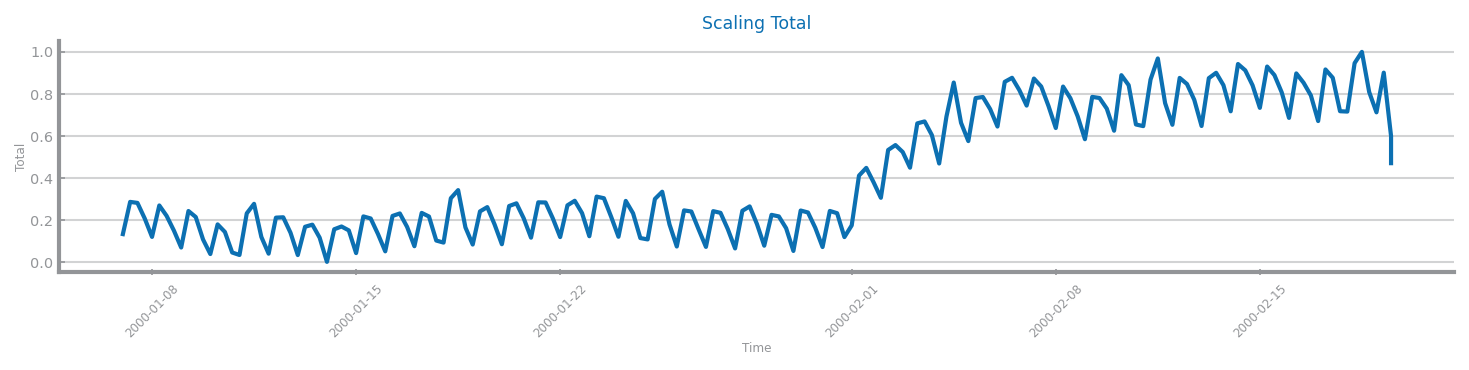

In [2]:
target = "Total"
chart_target = "Total"
file_tag = "Scaling"
timecol = "timestamp"

train_path = "../data/prepared/scaling/traffic_train_scaling.csv" 
test_path  = "../data/prepared/scaling/traffic_test_scaling.csv"

train_df = read_csv(train_path, parse_dates=["Time"], index_col="Time")
train: Series = train_df[target]
train.index = to_datetime(train.index)  # ensure proper datetime index

# Load test
test_df = read_csv(test_path, parse_dates=["Time"], index_col="Time")
test: Series = test_df[target]
test.index = to_datetime(test.index)

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    train.index.to_list(),
    train.to_list(),
    xlabel=train.index.name,
    ylabel=target,
    title=f"{file_tag} {target}",
)
show()

In [3]:
train.head()

Time
2000-01-07 00:00:00    0.132266
2000-01-07 06:00:00    0.285652
2000-01-07 12:00:00    0.280862
2000-01-07 18:00:00    0.206619
2000-01-08 00:00:00    0.118877
Name: Total, dtype: float64

In [4]:
test.head()

Time
2000-02-19 12:00:00    0.599499
2000-02-19 12:00:00    0.470063
2000-02-19 18:00:00    0.465600
2000-02-20 00:00:00    0.486283
2000-02-20 06:00:00    0.471478
Name: Total, dtype: float64

## Persistence Model

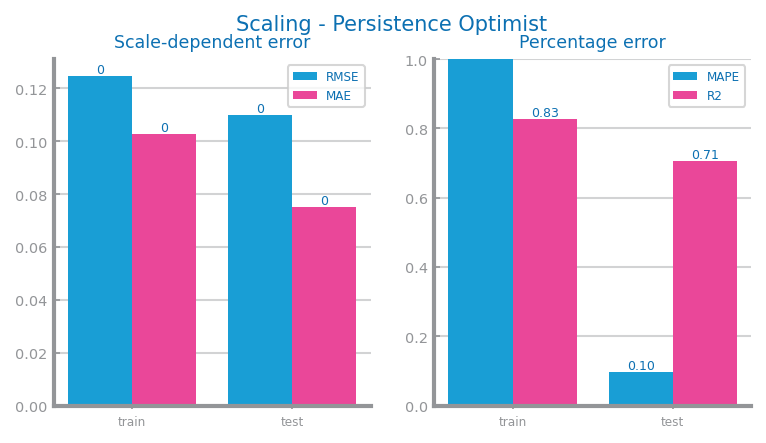

In [5]:
fr_mod = PersistenceOptimistRegressor()
fr_mod.fit(train)
prd_trn: Series = fr_mod.predict(train)
prd_tst: Series = fr_mod.predict(test)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Persistence Optimist")
savefig(f"../charts/forecasting/{file_tag}_persistence_optim_eval.png")

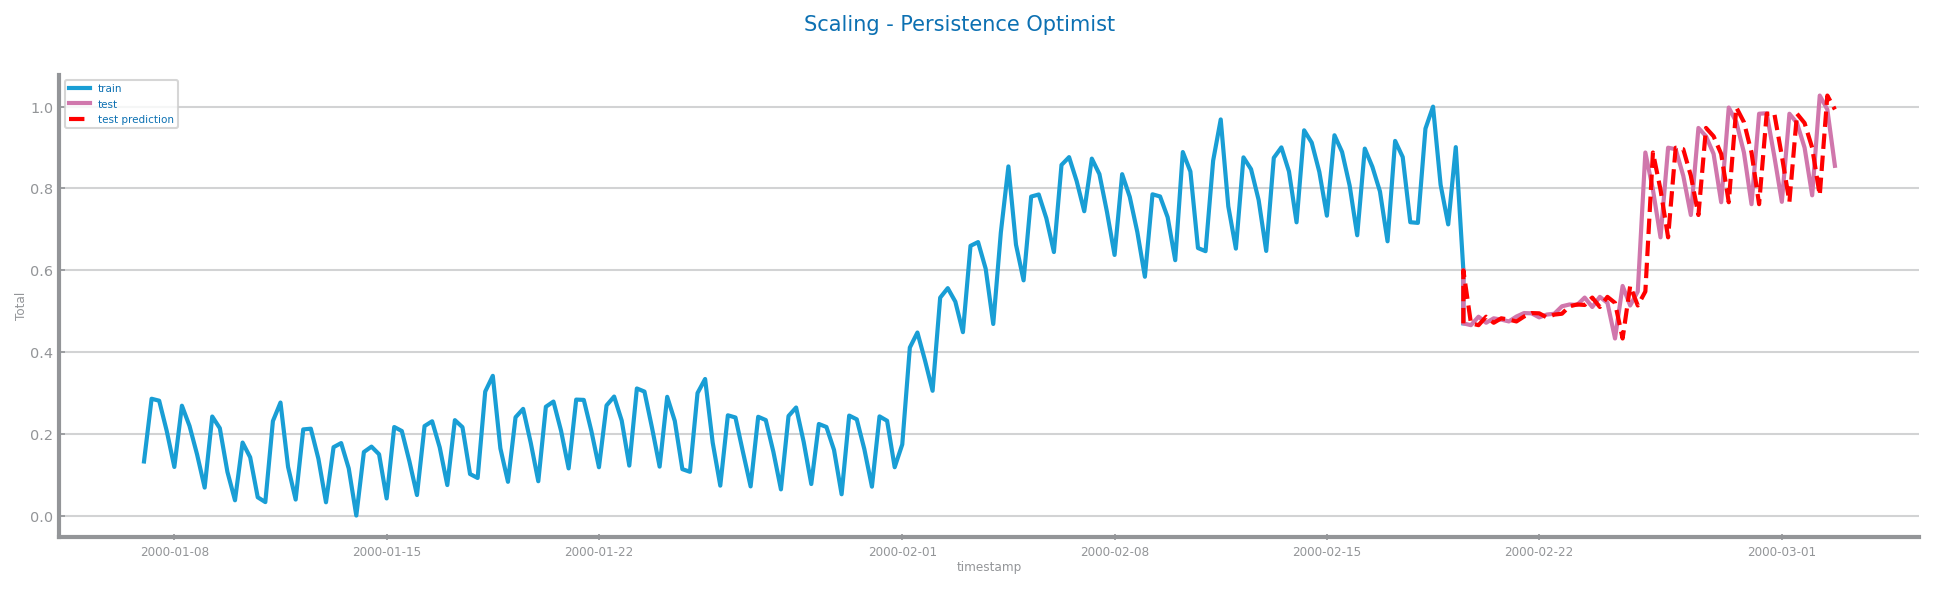

In [6]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Persistence Optimist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../charts/forecasting/{file_tag}_persistence_optim_forecast.png")

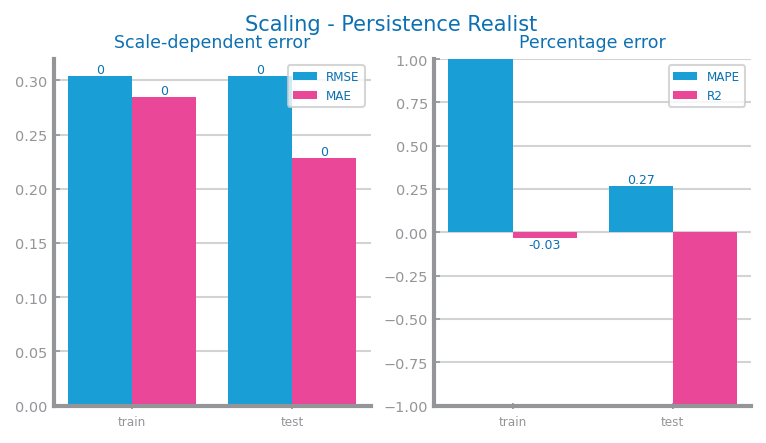

In [7]:
fr_mod = PersistenceRealistRegressor()
fr_mod.fit(train)
prd_trn: Series = fr_mod.predict(train)
prd_tst: Series = fr_mod.predict(test)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Persistence Realist")
savefig(f"../charts/forecasting/{file_tag}_persistence_real_eval.png")

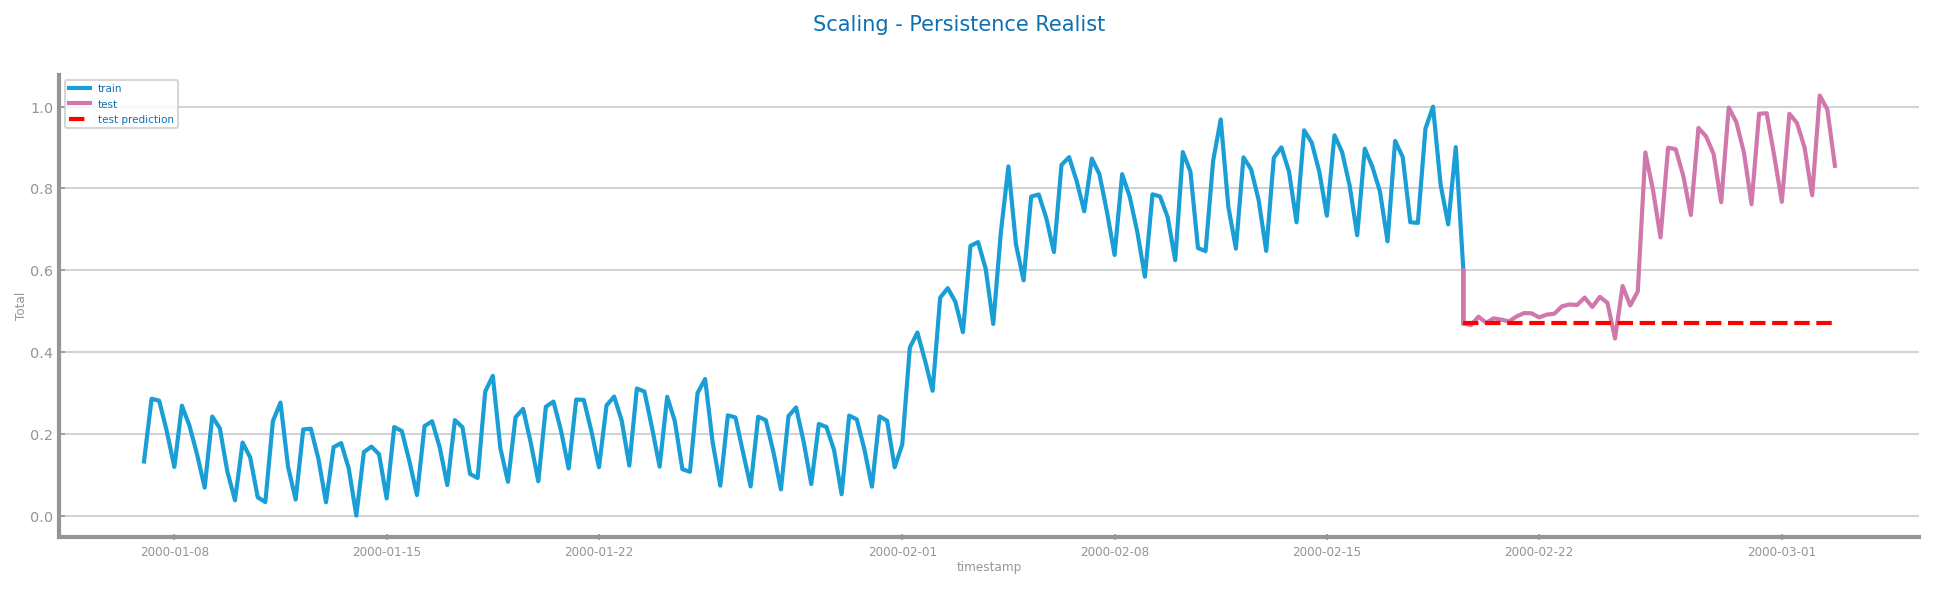

In [8]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../charts/forecasting/{file_tag}_persistence_real_forecast.png")

## Exponential Smoothing

Exponential Smoothing best with alpha=0 -> R2=-0.008326672809857438


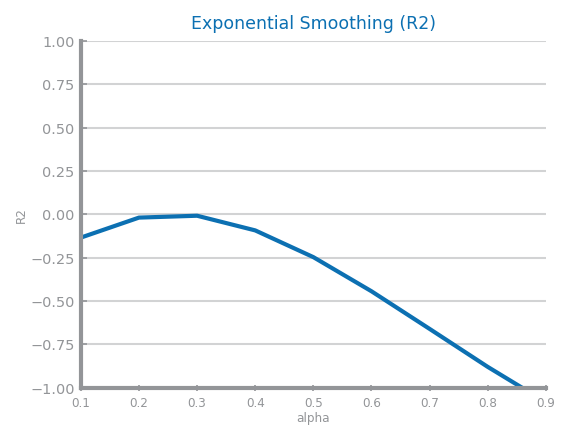

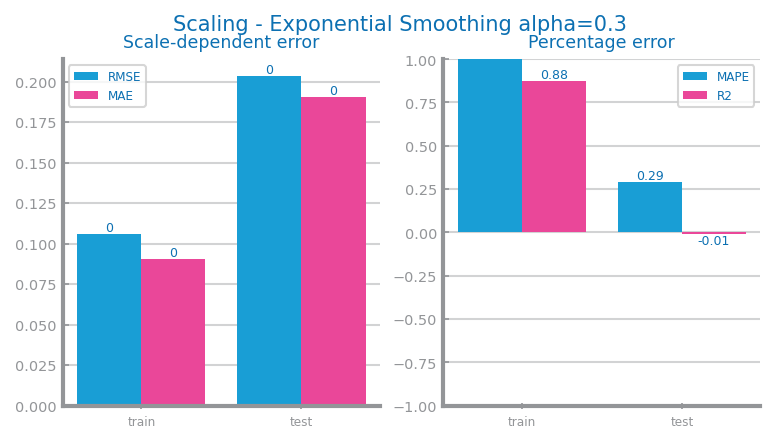

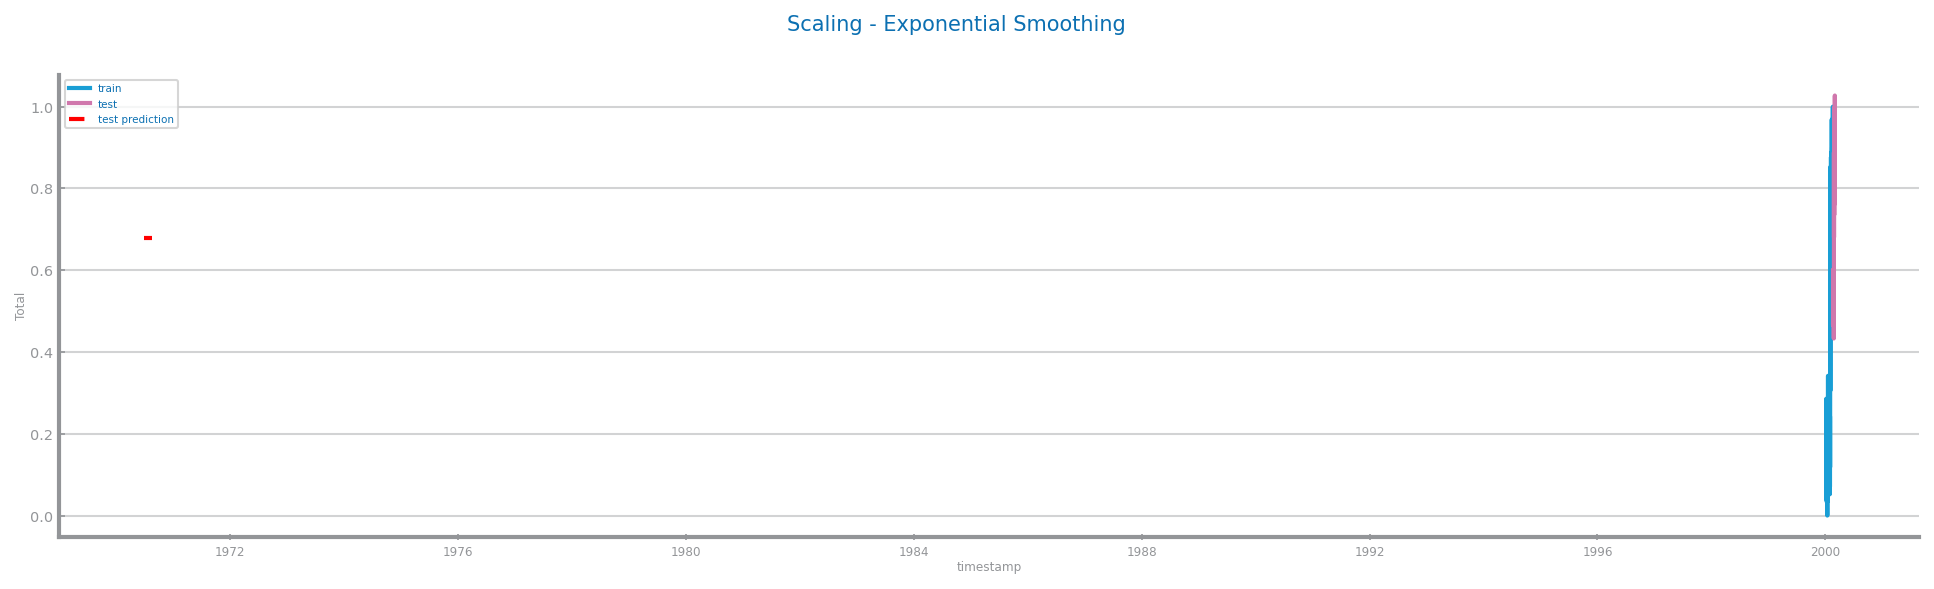

Exponential Smoothing best with alpha=0 -> MAPE=0.3328650077682933


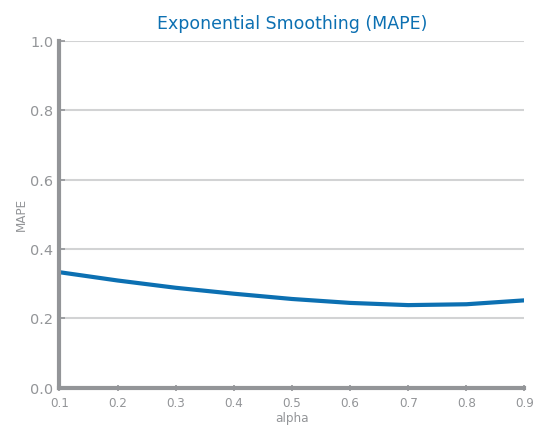

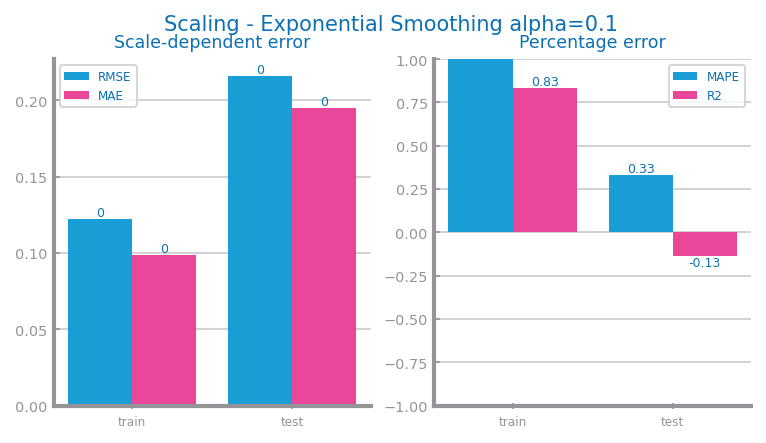

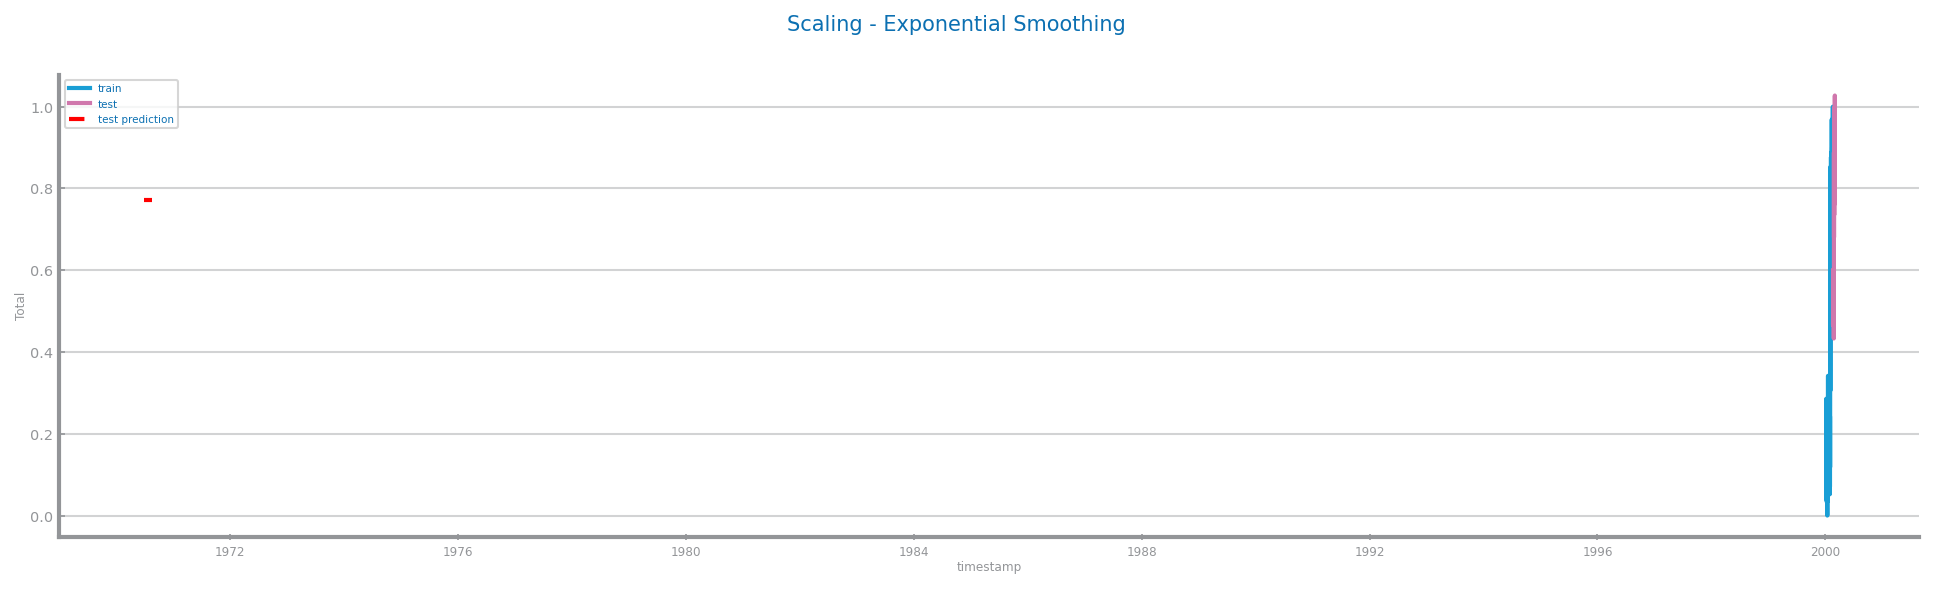

In [9]:
measures = ["R2","MAPE"]
for measure in measures:
    best_model, best_params = exponential_smoothing_study(train, test, measure=measure)
    savefig(f"../charts/forecasting/{file_tag}_exponential_smoothing_{measure}_study.png")
    show()

    params = best_params["params"]
    prd_trn = best_model.predict(start=0, end=len(train) - 1)
    prd_tst = best_model.forecast(steps=len(test))

    plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Exponential Smoothing alpha={params[0]}")
    savefig(f"../charts/forecasting/{file_tag}_exponential_smoothing_{measure}_eval.png")
    show()

    plot_forecasting_series(
        train,
        test,
        prd_tst,
        title=f"{file_tag} - Exponential Smoothing ",
        xlabel=timecol,
        ylabel=target,
    )
    savefig(f"../charts/forecasting/{file_tag}_exponential_smoothing_{measure}_forecast.png")
    show()      

## Rolling Mean

In [10]:
measures = ["R2","MAPE"]
for measure in measures:
    fig = figure(figsize=(HEIGHT, HEIGHT))
    best_model, best_params = rolling_mean_study(train, test)
    savefig(f"../charts/forecasting/{file_tag}_rollingmean_{measure}_study.png")
    show()

    params = best_params["params"]
    prd_trn: Series = best_model.predict(train)
    prd_tst: Series = best_model.predict(test)

    plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Rolling Mean (win={params[0]})")
    savefig(f"../charts/forecasting/{file_tag}_rollingmean_{measure}_win{params[0]}_eval.png")
    show()

    plot_forecasting_series(
        train,
        test,
        prd_tst,
        title=f"{file_tag} - Rolling Mean (win={params[0]})",
        xlabel=timecol,
        ylabel=target,
    )
    savefig(f"../charts/forecasting/{file_tag}_rollingmean_{measure}_forecast.png")
    show()      

ValueError: Length mismatch: Expected axis has 35 elements, new values have 51 elements

<Figure size 600x600 with 0 Axes>

## Linear Regression

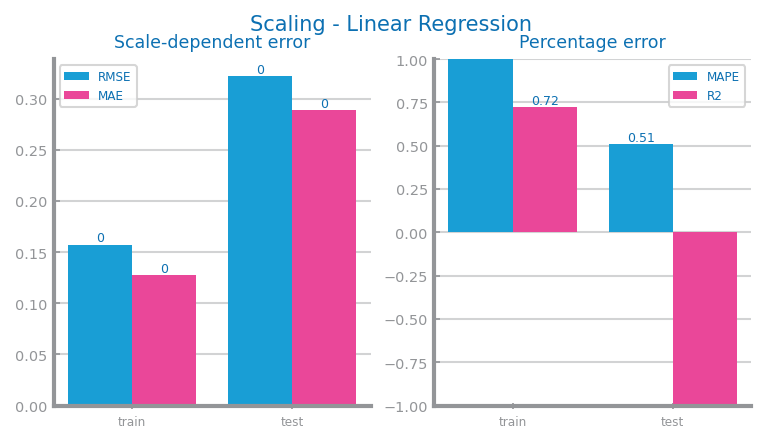

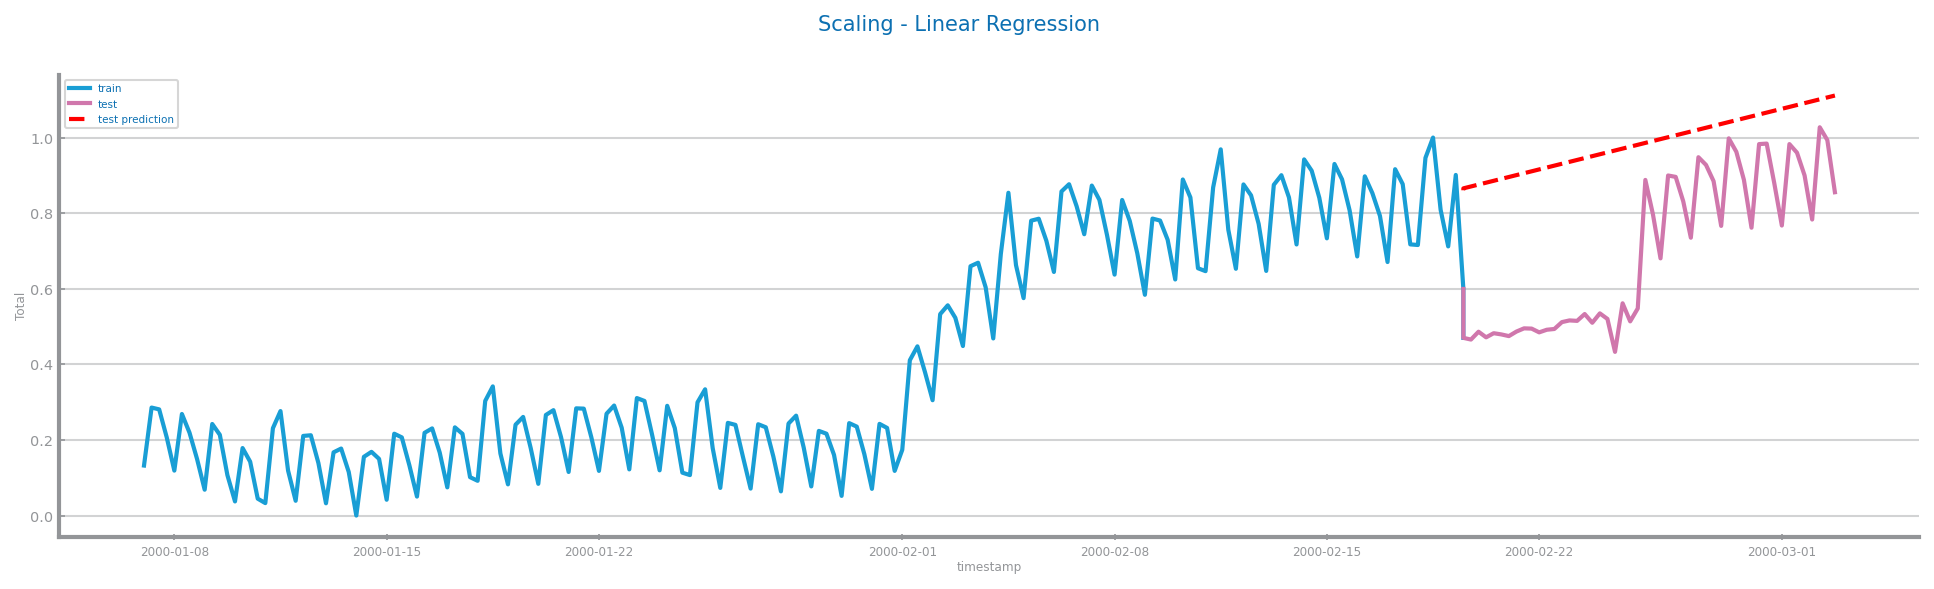

In [11]:
trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(train)+len(test)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression")
savefig(f"../charts/forecasting/{file_tag}_linear_regression_eval.png")
show()

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../charts/forecasting/{file_tag}_linear_regression_forecast.png")
show()

## ARIMA

In [12]:
predictor = ARIMA(train, order=(3, 1, 2))
model = predictor.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  176
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 261.595
Date:                Tue, 16 Dec 2025   AIC                           -511.191
Time:                        10:36:43   BIC                           -492.202
Sample:                             0   HQIC                          -503.489
                                - 176                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8712      0.055    -15.973      0.000      -0.978      -0.764
ar.L2         -0.9905      0.027    -37.060      0.000      -1.043      -0.938
ar.L3         -0.8360      0.058    -14.342      0.0

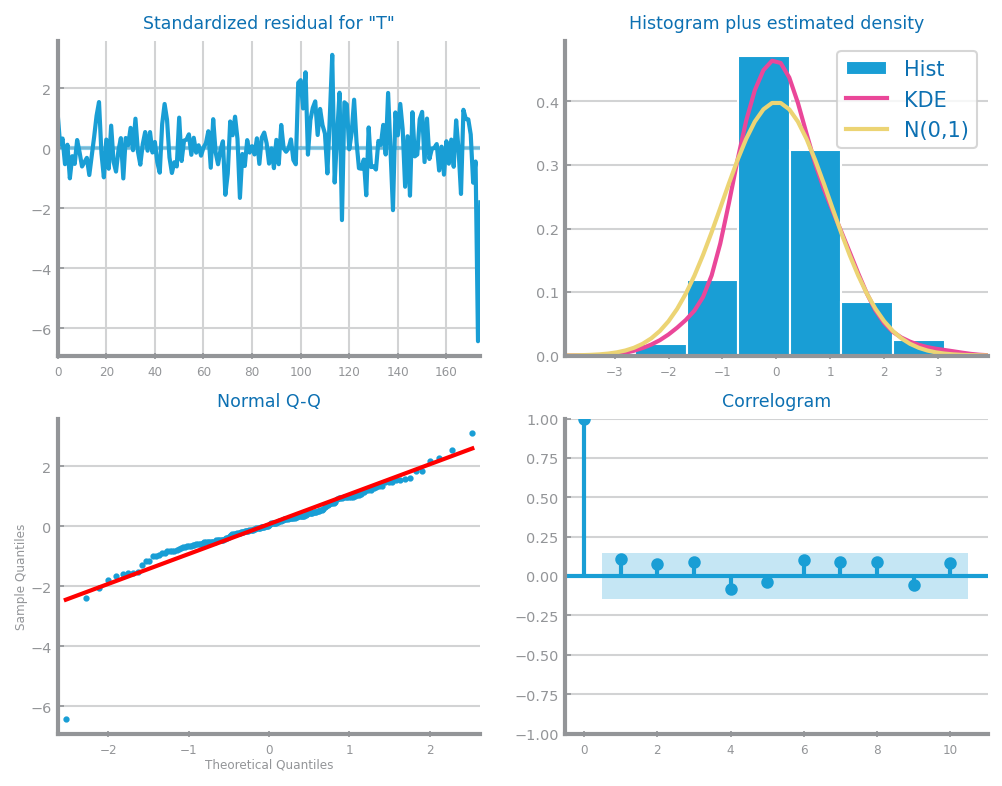

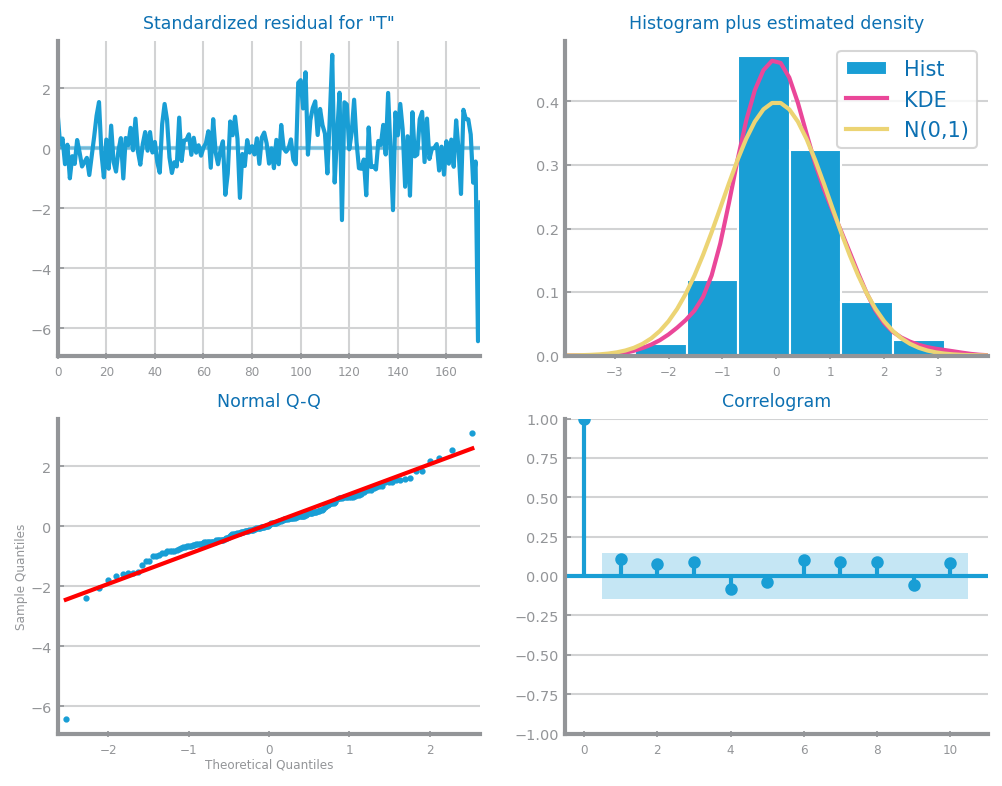

In [13]:
model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))

ARIMA best results achieved with (p,d,q)=(2, 2, 1) ==> measure=0.26


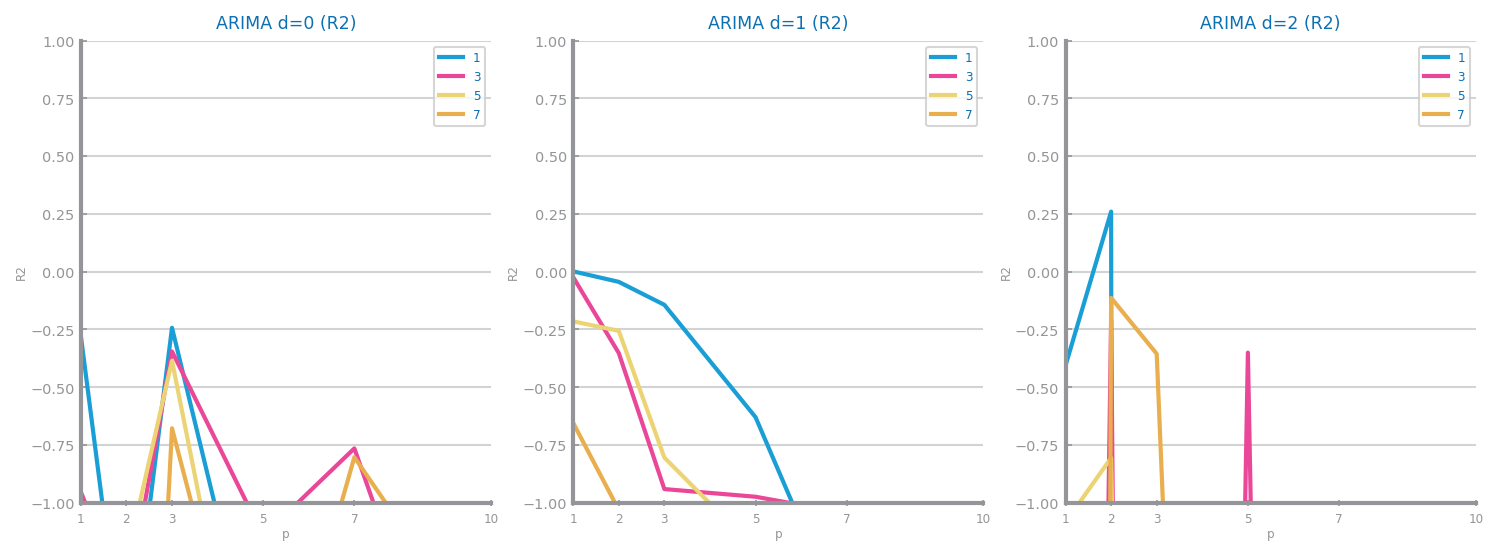

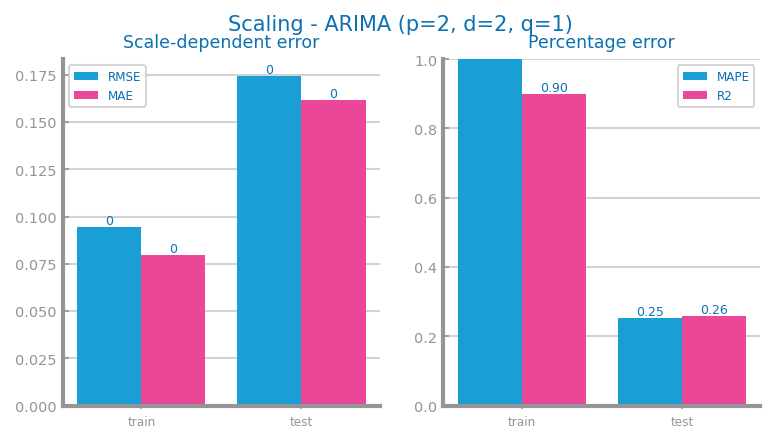

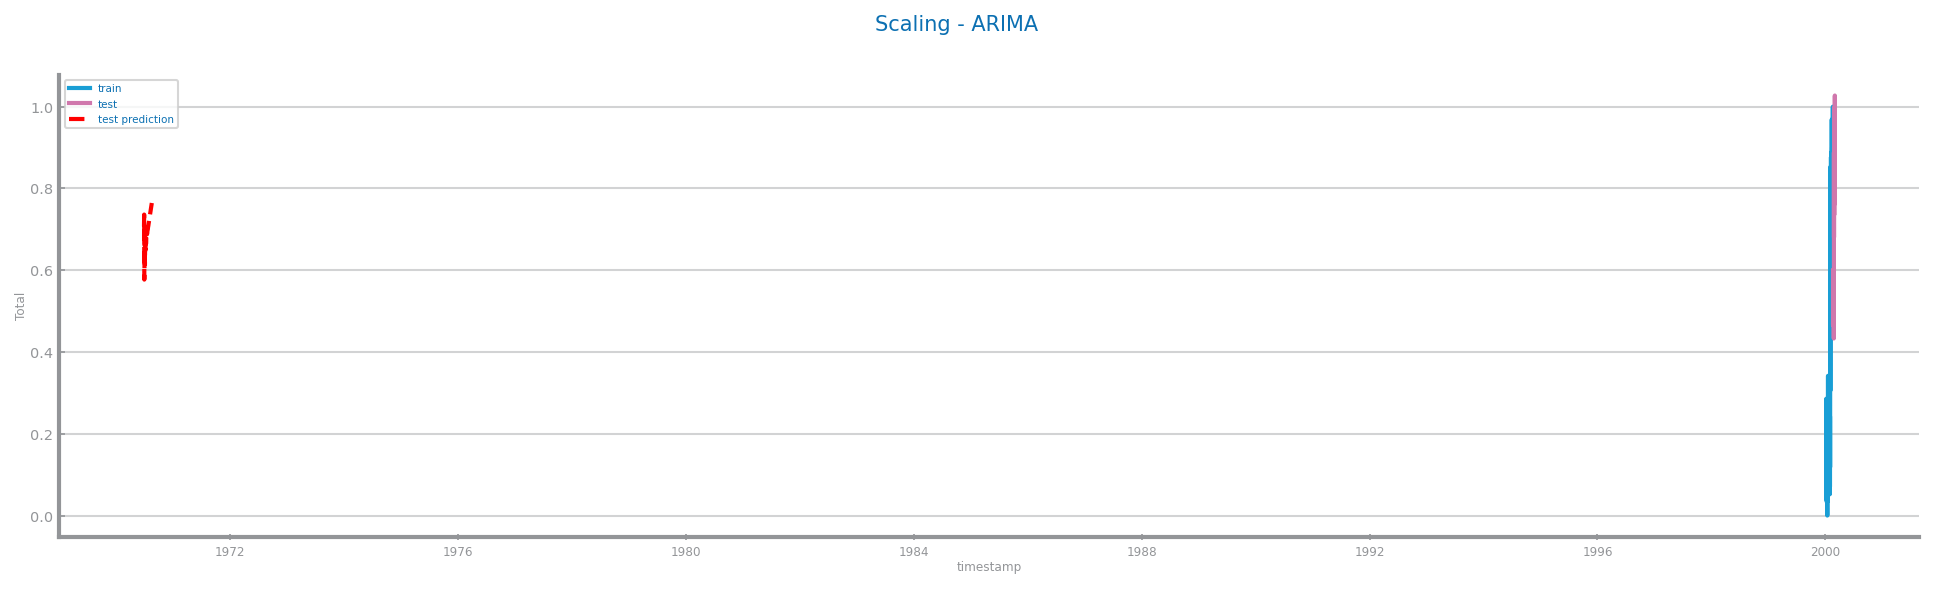

In [14]:
best_model, best_params = arima_study(train, test, measure=measure)
savefig(f"../charts/forecasting/{file_tag}_arima_{measure}_study.png")
show()

params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))

plot_forecasting_eval(
    train, test, prd_trn, prd_tst, title=f"{file_tag} - ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"../charts/forecasting/{file_tag}_arima_{measure}_eval.png")
show()

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - ARIMA ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../charts/forecasting/{file_tag}_arima_{measure}_forecast.png")
show()

## LSTMs

In [15]:
model = DS_LSTM(train, input_size=1, hidden_size=50, num_layers=1)
loss = model.fit()
print(loss)

ValueError: input must have the type torch.float32, got type torch.float64

ValueError: input must have the type torch.float32, got type torch.float64

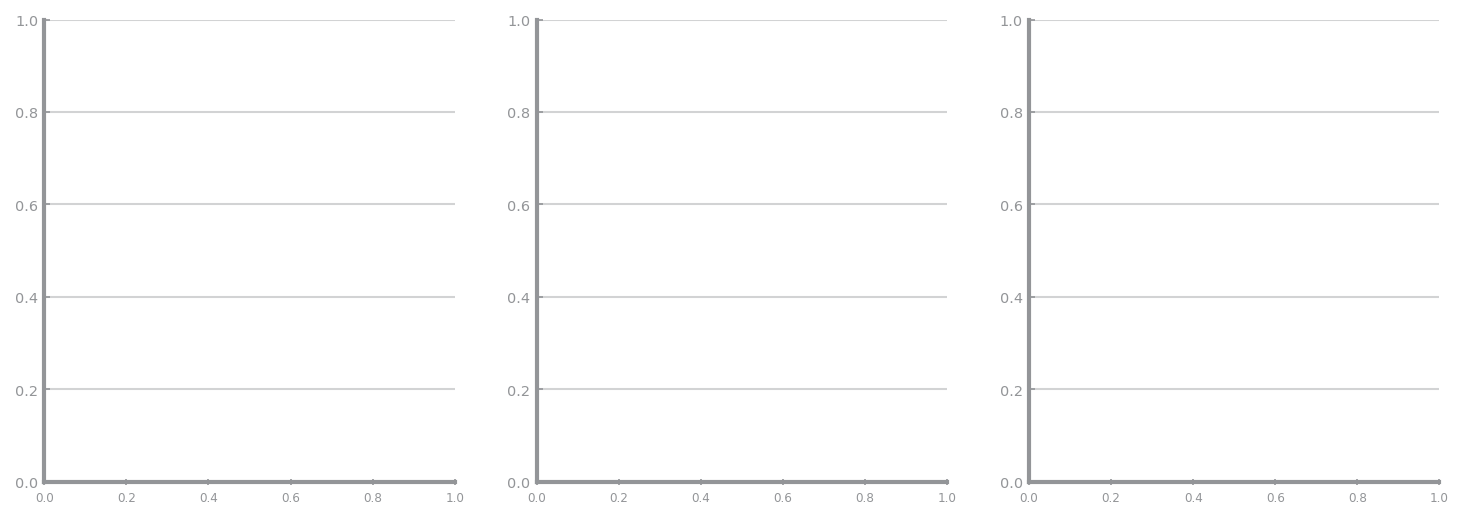

In [16]:
best_model, best_params = lstm_study(train, test, nr_episodes=3000, measure=measure)

In [18]:
params = best_params["params"]
best_length = params[0]
trnX, trnY = prepare_dataset_for_lstm(train, seq_length=best_length)
tstX, tstY = prepare_dataset_for_lstm(test, seq_length=best_length)

prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

plot_forecasting_eval(
    train[best_length:],
    test[best_length:],
    prd_trn,
    prd_tst,
    title=f"{file_tag} - LSTM (length={best_length}, hidden={params[1]}, epochs={params[2]})",
)
savefig(f"../charts/forecasting/{file_tag}_lstms_{measure}_eval.png")

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [19]:
pred_series: Series = Series(prd_tst.numpy().ravel(), index=test.index[best_length:])

plot_forecasting_series(
    train[best_length:],
    test[best_length:],
    pred_series,
    title=f"{file_tag} - LSTMs ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../charts/forecasting/{file_tag}_lstms_{measure}_forecast.png")

AttributeError: 'Series' object has no attribute 'numpy'